In [1]:
import os
import itertools
from PIL import Image

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix ,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:


# Define the test dataset path:
test_data="/content/drive/MyDrive/DMML2/chest_xray/test/"

# Initializing empty lists:
image_pathes=[]
labels=[]

# Creating Loop through files in the test dataset:
files=os.listdir(test_data)
for file in files:
    file_bath=os.path.join(test_data,file)

# Creating Loop through images in each folder:
    images=os.listdir(file_bath)
    for image in images:
        image_bath=os.path.join(file_bath , image)
        image_pathes.append(image_bath) # Append image paths and labels to lists:
        labels.append(file)

# Creating pandas Series objects:
Fseries =pd.Series(image_pathes,name="image_pathes")
lseries=pd.Series(labels,name="labels")

#Concatenate Series into DataFrame
test_df=pd.concat([Fseries,lseries],axis=1)

<Axes: xlabel='labels', ylabel='count'>

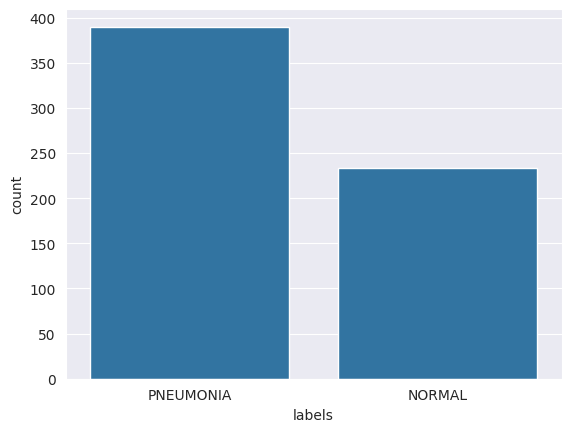

In [3]:
# Count the occurrences of each label in the "labels" column
label_counts = test_df['labels'].value_counts()

# Create a countplot using seaborn
sns.set_style('darkgrid')
sns.countplot(data=test_df, x='labels')


In [4]:
train_data="/content/drive/MyDrive/DMML2/chest_xray/train/"
image_pathes=[]
labels=[]

files=os.listdir(train_data)
for file in files:
    file_path=os.path.join(train_data,file)
    images=os.listdir(file_path)
    for image in images:
        image_path=os.path.join(file_path,image)
        image_pathes.append(image_path)
        labels.append(file)

fseries=pd.Series(image_pathes, name="image_pathes")
lseries=pd.Series(labels,name="labels")
train_df=pd.concat([fseries,lseries],axis=1)

<Axes: xlabel='labels', ylabel='count'>

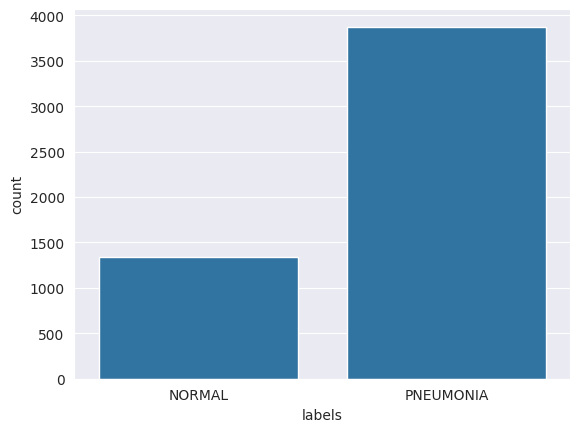

In [5]:
# Count the occurrences of each label in the "labels" column
label_counts = train_df['labels'].value_counts()

# Create a countplot using seaborn
sns.set_style('darkgrid')
sns.countplot(data=train_df, x='labels')

In [6]:
val_data="/content/drive/MyDrive/DMML2/chest_xray/val/"
image_pathes=[]
labels=[]

files=os.listdir(val_data)
for file in files:
    file_path=os.path.join(val_data,file)
    images=os.listdir(file_path)
    for image in images:
        image_path=os.path.join(file_path,image)
        image_pathes.append(image_path)
        labels.append(file)

fseries=pd.Series(image_pathes, name="image_pathes")
lseries=pd.Series(labels,name="labels")
valid_df=pd.concat([fseries,lseries],axis=1)

<Axes: xlabel='labels', ylabel='count'>

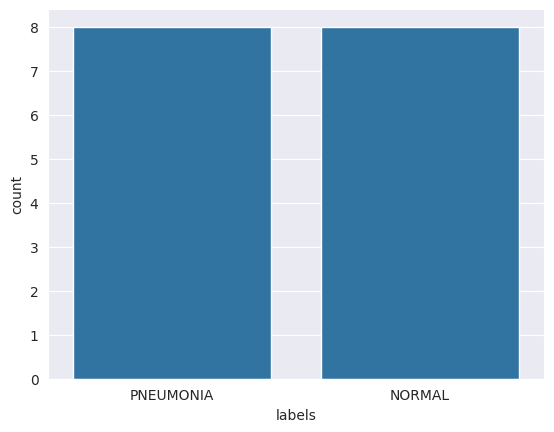

In [7]:
# Count the occurrences of each label in the "labels" column
label_counts = valid_df['labels'].value_counts()

# Create a countplot using seaborn
sns.set_style('darkgrid')
sns.countplot(data=valid_df, x='labels')

In [8]:
# Image preprocessing
batch_size=16
image_size=(224,224)

df_gen=ImageDataGenerator()

train_gen = df_gen.flow_from_dataframe(train_df, x_col="image_pathes", y_col="labels", batch_size=batch_size,
                                       target_size=image_size, class_mode="categorical", shuffle=True,
                                       color_mode="grayscale")

test_gen = df_gen.flow_from_dataframe(test_df, x_col="image_pathes", y_col="labels", target_size=image_size,
                                      batch_size=batch_size, shuffle=True, class_mode="categorical",
                                      color_mode="grayscale")

valid_gen = df_gen.flow_from_dataframe(valid_df, x_col="image_pathes", y_col="labels", target_size=image_size,
                                       batch_size=batch_size, shuffle=True, class_mode="categorical",
                                       color_mode="grayscale")

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


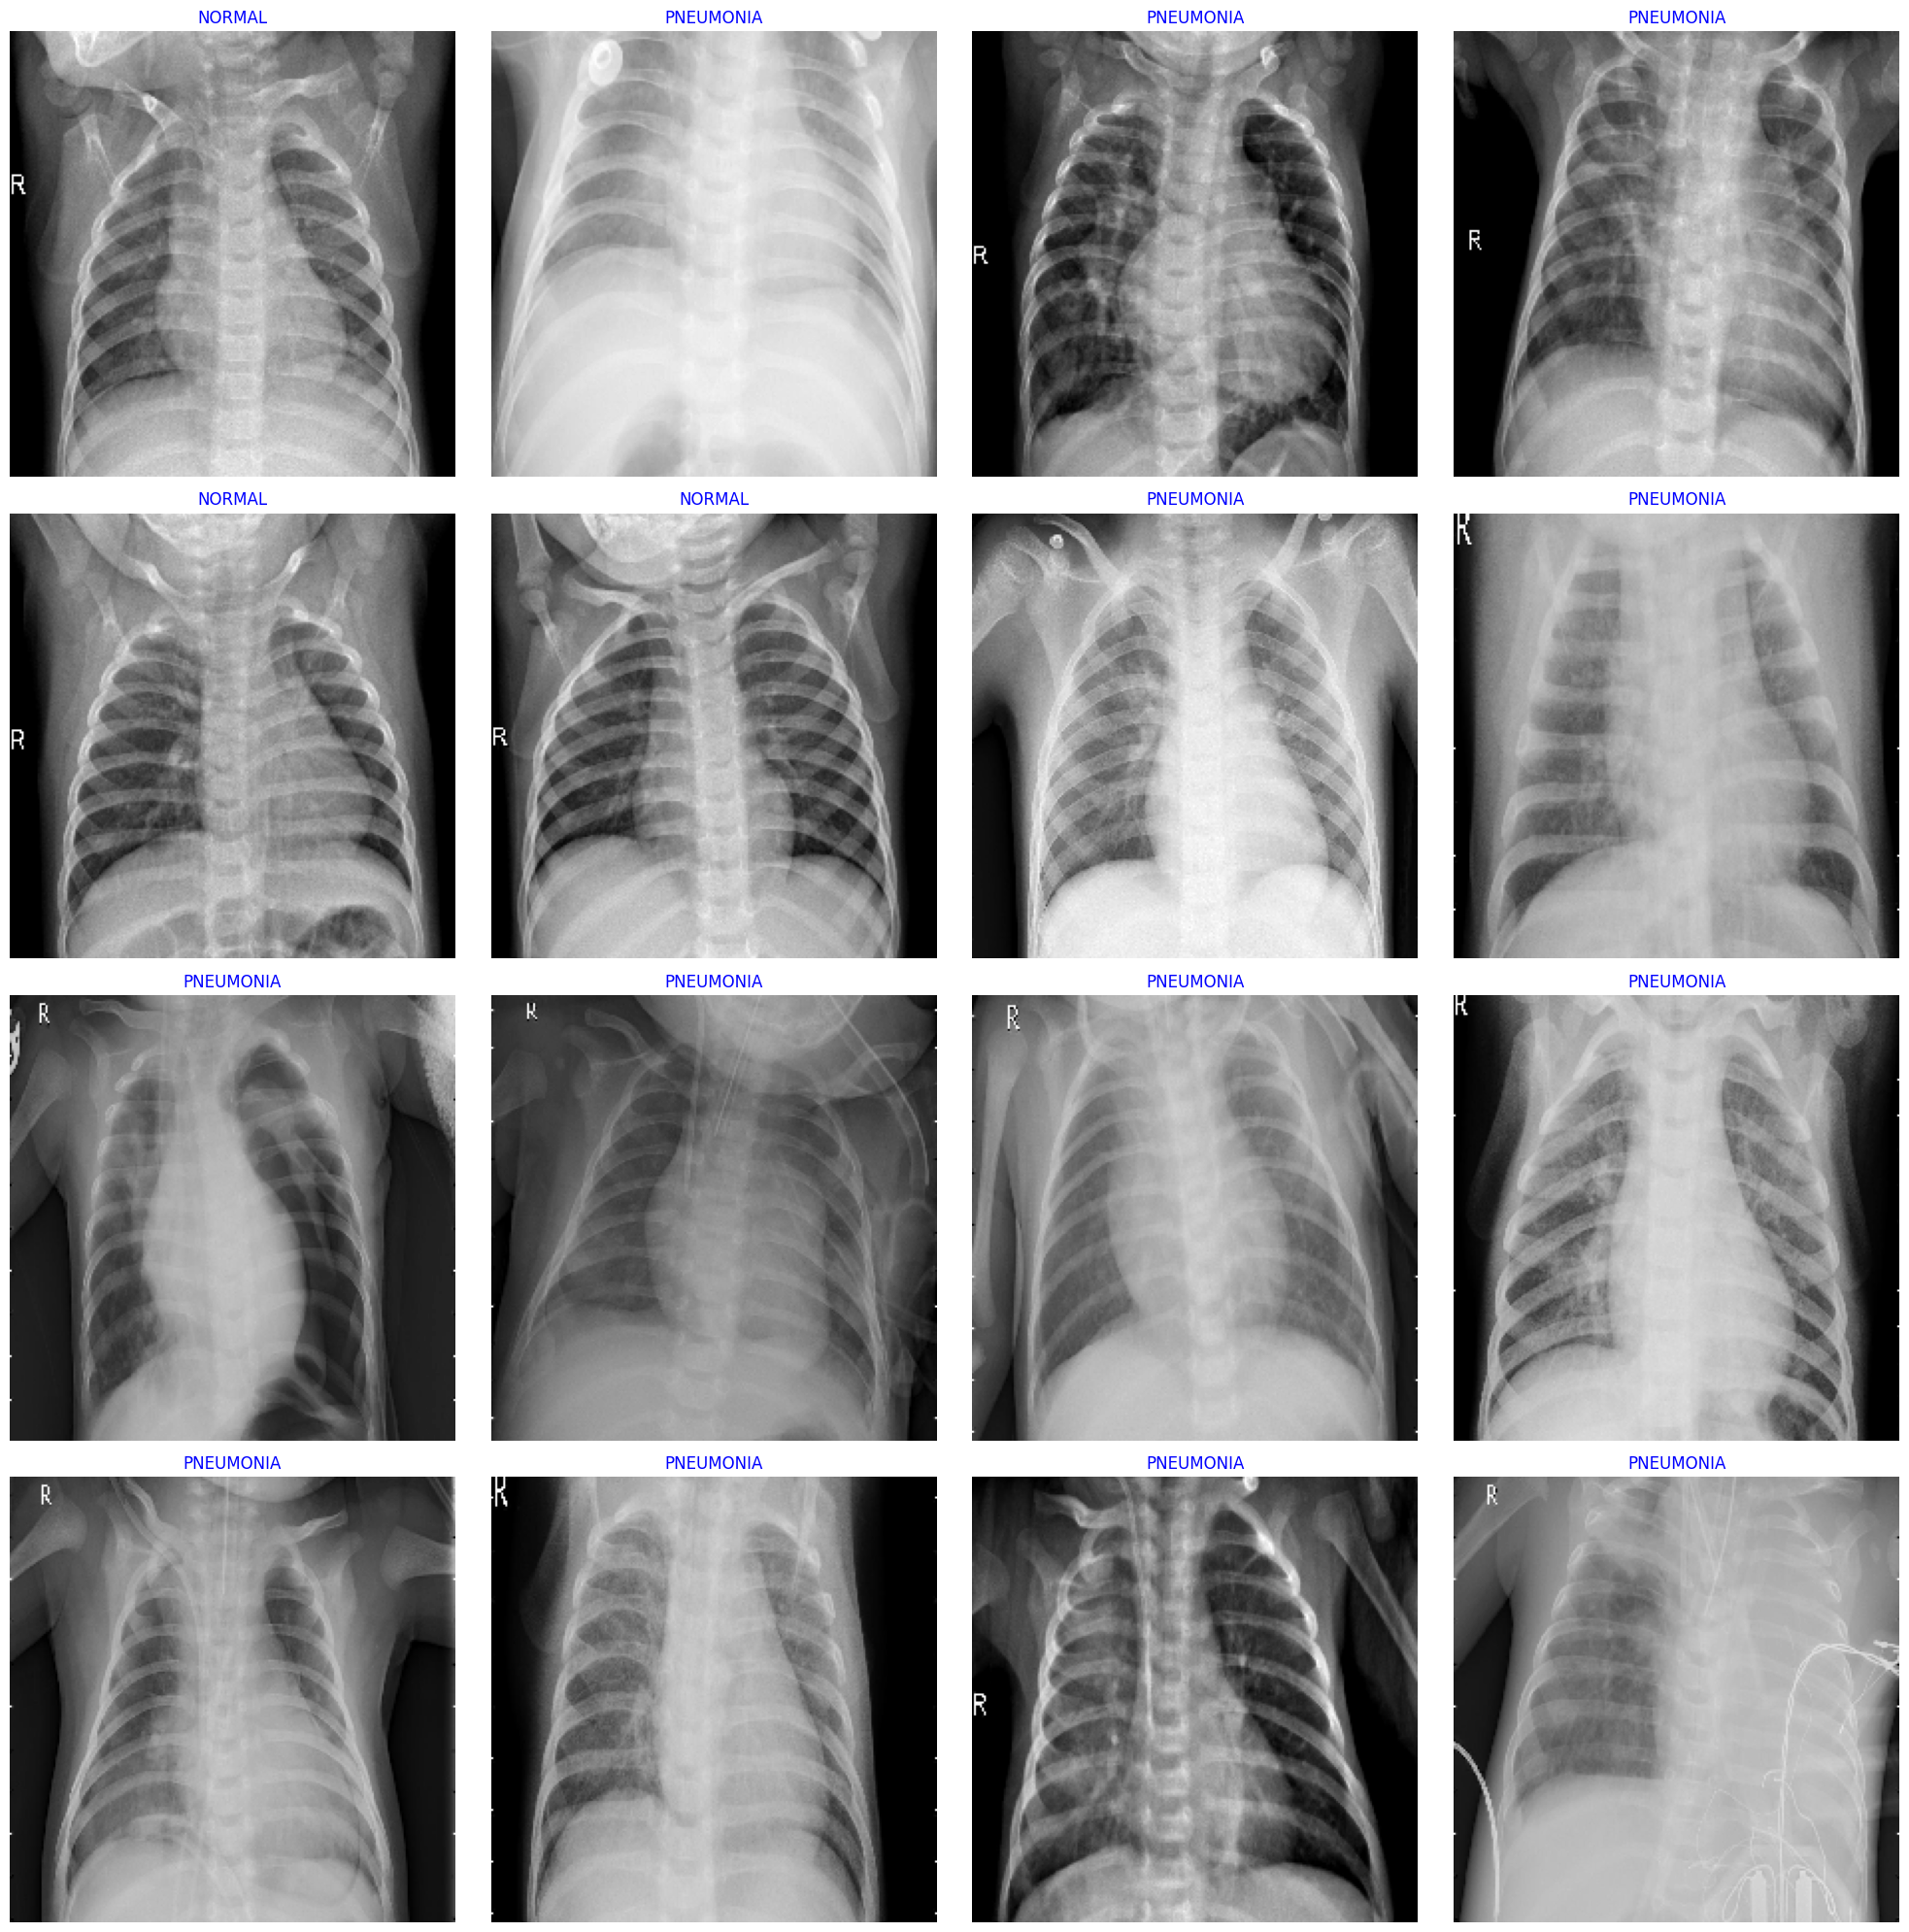

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image, cmap='gray')
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
def calculate_features(model, img_shape):
    features = []
    input_shape = img_shape
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            filters = layer.filters
            kernel_size = layer.kernel_size[0]  #  square kernel
            padding = layer.padding.lower()
            stride = layer.strides[0]  # equal stride in both dimensions

            if padding == 'same':
                # Compute output shape with 'same' padding
                output_height = input_shape[0] // stride
                output_width = input_shape[1] // stride
            else:
                # Compute output shape with 'valid' padding
                output_height = (input_shape[0] - kernel_size + 1) // stride
                output_width = (input_shape[1] - kernel_size + 1) // stride

            num_features = output_height * output_width * filters
            features.append(num_features)

            # Update input shape for the next layer
            input_shape = (output_height, output_width, filters)

    return features

In [11]:
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.2),

    Dense(256,activation = "relu"),
    Dropout(0.2),
    Dense(64,activation = "relu"),
    Dropout(0.2),
    Dense(64,activation = "relu"),
    Dropout(0.2),
    Dense(class_count, activation = "softmax")
])

# Display the summary of the model architecture including layer types, output shapes, and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                        

In [12]:
# Compile the model with specified optimizer, loss function, and metrics
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
img_shape = (224, 224, 1)  # Input image shape
features = calculate_features(model, img_shape)
print("Number of features in each convolutional layer:", features)

Number of features in each convolutional layer: [3211264, 3211264, 6422528, 6422528, 12845056, 12845056, 12845056, 25690112, 25690112, 25690112]


In [14]:
epochs=5
history=model.fit(train_gen,epochs=epochs ,validation_data=valid_gen ,verbose=1)

Epoch 1/5
326/326 [==============================] - 1158s 4s/step - loss: 1.1637 - accuracy: 0.8669 - val_loss: 25.6836 - val_accuracy: 0.5625
Epoch 2/5
326/326 [==============================] - 778s 2s/step - loss: 0.3169 - accuracy: 0.9279 - val_loss: 3.1990 - val_accuracy: 0.5625
Epoch 3/5
326/326 [==============================] - 779s 2s/step - loss: 0.1897 - accuracy: 0.9471 - val_loss: 6.8082 - val_accuracy: 0.5625
Epoch 4/5
326/326 [==============================] - 781s 2s/step - loss: 0.1327 - accuracy: 0.9594 - val_loss: 4.0512 - val_accuracy: 0.6250
Epoch 5/5
326/326 [==============================] - 783s 2s/step - loss: 0.1670 - accuracy: 0.9542 - val_loss: 0.1170 - val_accuracy: 0.9375


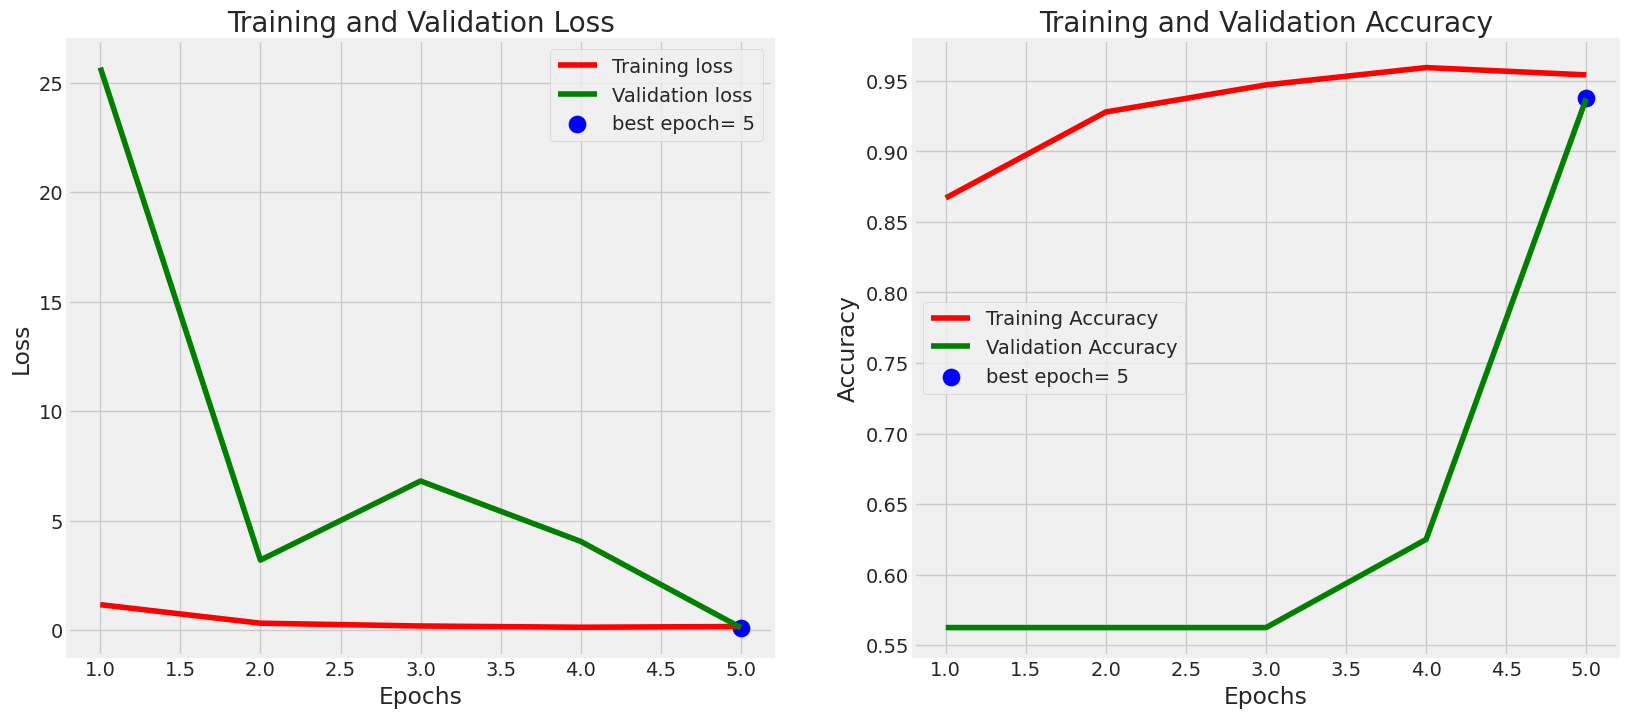

In [15]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
train_score=model.evaluate(train_gen , verbose=1)
valid_score=model.evaluate(valid_gen , verbose=1)
test_score=model.evaluate(test_gen , verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("valid Loss: ", valid_score[0])
print("valid Accuracy: ", valid_score[1])
print('-' * 20)
print("test Loss: ", test_score[0])
print("test Accuracy: ", test_score[1])
print('-' * 20)

39/39 [==============================] - 150s 4s/step - loss: 1.4326 - accuracy: 0.7965
Train Loss:  0.08220142871141434
Train Accuracy:  0.9737346768379211
--------------------
valid Loss:  0.1170455664396286
valid Accuracy:  0.9375
--------------------
test Loss:  1.432644009590149
test Accuracy:  0.7964743375778198
--------------------


In [17]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

39/39 [==============================] - 15s 380ms/step


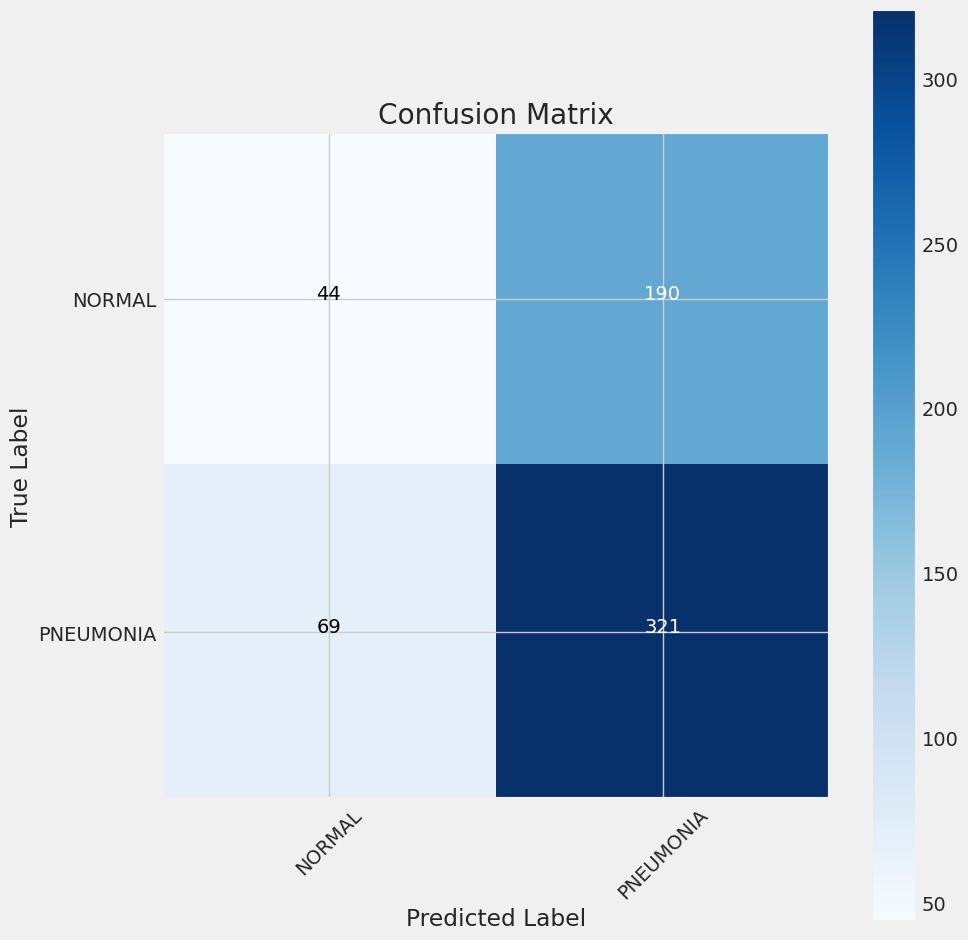

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      NORMAL       0.39      0.19      0.25       234
   PNEUMONIA       0.63      0.82      0.71       390

    accuracy                           0.58       624
   macro avg       0.51      0.51      0.48       624
weighted avg       0.54      0.58      0.54       624

